In [ ]:
!pip install --upgrade transformers


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 38.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 26.5 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.19.1
    Uninstalling tokenizers-0.19.1:
      Successfully uninstalled tokenizers-0.19.1
  Attempting uninstall: transformers
    Found existing installation: transformers 4.44.2
    Uninstalling transformers-4.44.2:
      Successfully uninstalled transformers-4.44.2


In [1]:
import os
import re
import torch
import matplotlib.pyplot as plt
import pandas as pd
from torch import nn
from torch.utils.data import DataLoader, Dataset
from transformers import AlbertTokenizer, AlbertForSequenceClassification
from transformers import XLNetTokenizer, XLNetForSequenceClassification
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from transformers import BertTokenizer,RobertaTokenizer, DebertaTokenizer
from transformers import BertModel, RobertaModel, DebertaModel
from transformers import BertForSequenceClassification, RobertaForSequenceClassification, DebertaForSequenceClassification
from transformers import AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, f1_score, precision_score, recall_score


In [54]:
def clean_review_text(text):
    """
    Perform text cleaning by lowercasing, expanding contractions,
    removing URLs, special characters, and non-alphabetical characters.

    Args:
        text (str): Input text to be cleaned.

    Returns:
        str: Cleaned text.
    """
    #text = text.lower()  # Convert to lowercase
    text = re.sub(r" '", "'", text)  # Fix space issues with apostrophes
    text = re.sub(r'<.*?>', '', text) # Remove HTML tags
    text = re.sub(r'http\S+', '', text) # Remove URLs
    text = re.sub(r"[^a-zA-Z0-9.\s]", "", text)  # Remove non-alphanumeric characters, except for periods and whitespace
    text = re.sub(r"\s+", " ", text).strip() # # Remove leading and trailing whitespace
    return text

In [55]:
def load_reviews_from_file(file_path):
    """
    Load reviews from the specified text file and preprocess the reviews.

    Args:
        file_path (str): Path to the text file containing the reviews.

    Returns:
        pd.DataFrame: DataFrame containing processed reviews.
    """
    reviews = []
    with open(file_path, encoding='utf-8') as file:
        for line in file.readlines():
            reviews.append(line.strip())

    content = []
    label = []

    # Splitting the reviews based on spaces
    for review in reviews:
        parts = review.rsplit('\t', 1) # Split the review and label
        content.append(parts[0].strip())  # Add the content
        label.append(parts[1].strip())    # Add the label

    data = {'content': content, 'label': label}
    df = pd.DataFrame(data, columns=['content', 'label'])

    # Apply text preprocessing
    df['processed_content'] = df['content'].apply(clean_review_text)

    return df

In [4]:
from google.colab import drive

drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [56]:
file_path = '/content/gdrive/MyDrive/Learning from Data/project/train_clean.tsv'
if os.path.exists(file_path):
    df = load_reviews_from_file(file_path)
    print("File loaded successfully!")
else:
    print("File not found at the specified path.")

file_path_dev = '/content/gdrive/MyDrive/Learning from Data/project/dev_clean.tsv'
if os.path.exists(file_path_dev):
    df_dev = load_reviews_from_file(file_path_dev)
    print("File loaded successfully!")
else:
    print("File not found at the specified path.")

file_path_test = '/content/gdrive/MyDrive/Learning from Data/project/test_clean.tsv'
if os.path.exists(file_path_test):
    df_test = load_reviews_from_file(file_path_test)
    print("File loaded successfully!")
else:
    print("File not found at the specified path.")


File loaded successfully!
File loaded successfully!
File loaded successfully!


In [9]:
#df = df[:2000]
df.head()

,content,label,processed_content
0,@USER She should ask a few native Americans wh...,OFF,USER She should ask a few native Americans wha...
1,@USER @USER Go home you’re drunk!!! @USER HASH...,OFF,USER USER Go home youre drunk USER HASHTAG HAS...
2,Amazon is investigating Chinese employees who ...,NOT,Amazon is investigating Chinese employees who ...
3,"""@USER Someone should'veTaken"""" this piece of ...",OFF,USER Someone shouldveTaken this piece of shit ...
4,@USER @USER Obama wanted liberals &amp; illega...,NOT,USER USER Obama wanted liberals amp illegals t...


Counts of each label in Train and Test sets:
       Train  Dev  Test
label                  
NOT     8192  648   620
OFF     4048  352   240


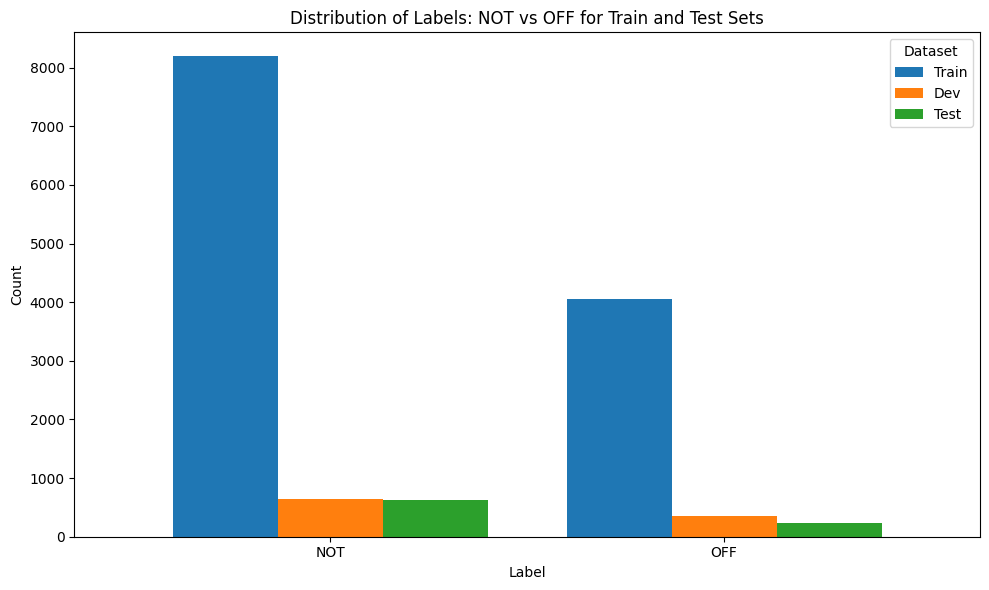

In [10]:
import seaborn as sns

# Count the occurrences of each label
label_counts = df['label'].value_counts()
label_counts_dev = df_dev['label'].value_counts()
label_counts_test = df_test['label'].value_counts()

combined_counts = pd.DataFrame({
    'Train': label_counts,
    'Dev': label_counts_dev,
    'Test': label_counts_test
}).fillna(0)  # Fill NaN with 0 for missing labels in either dataset

# Print the counts
print("Counts of each label in Train and Test sets:")
print(combined_counts)

# Create a bar plot
combined_counts.plot(kind='bar', figsize=(10, 6), width=0.8)
plt.title('Distribution of Labels: NOT vs OFF for Train and Test Sets')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.legend(title='Dataset')
plt.tight_layout()
plt.show()

In [57]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
reviews =  df['processed_content'].tolist()
labels = df['label'].tolist()
encoded_labels = label_encoder.fit_transform(labels)

reviews_dev =  df_dev['processed_content'].tolist()
labels_dev = df_dev['label'].tolist()
encoded_labels_dev = label_encoder.fit_transform(labels_dev)

reviews_test =  df_test['processed_content'].tolist()
labels_test = df_test['label'].tolist()
encoded_labels_test = label_encoder.fit_transform(labels_test)

In [58]:
class TextClassificationDataset(Dataset):
  """
    Custom Dataset for text classification tasks.

    Args:
        texts: List of input texts.
        labels: List of corresponding labels for each text.
        tokenizer: Tokenizer to convert text into input IDs and attention masks.
        max_length: Maximum sequence length for tokenized text.

    Methods:
        __len__: Returns the number of samples in the dataset.
        __getitem__: Retrieves a sample (tokenized text and corresponding label) at the given index.
    """
  def __init__(self, texts, labels, tokenizer, max_length):
    self.texts = texts
    self.labels = labels
    self.tokenizer = tokenizer
    self.max_length = max_length

  def __len__(self):
    return len(self.texts)
  def __getitem__(self, idx):
    text = str(self.texts[idx])
    label = self.labels[idx]
    encoding = self.tokenizer.encode_plus(text, return_tensors='pt', max_length=self.max_length, padding='max_length', truncation=True)
    return {'input_ids': encoding['input_ids'].flatten(), 'attention_mask': encoding['attention_mask'].flatten(), 'label': torch.tensor(label)}

In [59]:
class CustomClassifier(nn.Module):
    """
    A custom text classifier that supports multiple transformer-based models for sequence classification.

    Args:
        model_name (str): Name of the pre-trained transformer model to be used.
                         Options: 'bert', 'roberta', 'deberta', 'distilbert', 'xlnet', 'albert', 'tinybert'.
        num_classes (int): The number of output classes for classification (default is 6).

    Attributes:
        tokenizer: Tokenizer associated with the chosen transformer model.
        model: Sequence classification model based on the chosen transformer model.

    Methods:
        forward(input_ids, attention_mask):
            Forward pass to compute logits for input sequences.
        get_tokenizer():
            Returns the tokenizer for the model.
    """
    def __init__(self, model_name, num_classes=6):
        super(CustomClassifier, self).__init__()
        self.model_name = model_name.lower()
        self.num_classes = num_classes


        if self.model_name == 'tinybert':
            self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
            self.model = BertForSequenceClassification.from_pretrained( 'huawei-noah/TinyBERT_General_4L_312D', num_labels=self.num_classes)
        elif self.model_name == 'albert':
            self.tokenizer = AlbertTokenizer.from_pretrained('albert-base-v2')
            self.model = AlbertForSequenceClassification.from_pretrained('albert-base-v2', num_labels=self.num_classes)
        elif self.model_name == 'xlnet':
            self.tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased')
            self.model = XLNetForSequenceClassification.from_pretrained('xlnet-base-cased', num_labels=self.num_classes)
        elif self.model_name == 'bert':
            self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
            self.model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=self.num_classes)
        elif self.model_name == 'distilbert':
            self.tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
            self.model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=self.num_classes)
        elif self.model_name == 'roberta':
            self.tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
            self.model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=self.num_classes)

            #NB: roberta and debera use <s> for start token and </s> for end token
            self.tokenizer.padding_side = 'right'
            self.tokenizer.pad_token = self.tokenizer.eos_token
        elif self.model_name == 'deberta':
            self.tokenizer = DebertaTokenizer.from_pretrained('microsoft/deberta-base')
            self.model = DebertaForSequenceClassification.from_pretrained('microsoft/deberta-base', num_labels=self.num_classes)

            self.tokenizer.padding_side = 'right'
            self.tokenizer.pad_token = self.tokenizer.eos_token
        else:
            raise ValueError("Unsupported model name. Please choose from 'bert', 'roberta', 'deberta', 'distilbert', 'xlnet', 'albert', or 'tinybert'.")
        # Update the model config for models that need a specific pad token
        self.model.config.pad_token_id = self.tokenizer.pad_token_id


    def forward(self, input_ids, attention_mask):
        # Comput model outputs
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        return logits
    # Retruen the tokenizer for a specific model
    def get_tokenizer(self):
        return self.tokenizer

In [60]:
def train(model, dataloader, optimizer, scheduler, device):
    """
    Trains the model for one epoch.

    Args:
        model: The neural network model to be finetune.
        dataloader: DataLoader providing batches of input data and labels.
        optimizer: Optimizer for updating model parameters.
        scheduler: Learning rate scheduler to adjust learning rate during training.
        device: Device to run the training on (CPU or GPU).

    Returns:
        average_train_loss: Average training loss over all batches.
    """
    model.train()
    train_loss = 0
    for batch in dataloader:
        # Move inputs and labels to the designated device (GPU/CPU)
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        optimizer.zero_grad()  # Clear previous gradients
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)  # Forward pass

        loss = torch.nn.functional.cross_entropy(outputs, labels)
        train_loss += loss.item()
        loss.backward() # Backpropagation
        optimizer.step() # Update model parameters
        scheduler.step() # Update learning rate based on the scheduler
    average_train_loss = train_loss / len(dataloader) # Compute average loss over all batches
    return average_train_loss


In [61]:
def evaluate(model, dataloader, device):
  """
    Evaluate the finetuned model on a given dataset using the dataloader.

    Args:
        model: finetuned pretrained model to be evaluated
        dataloader: DataLoader object that provides batches of data for evaluation
        device: the processing unit ('cpu' or 'cuda') where the model is executed

    Returns:
        average_val_loss: The average loss over the validation set
        accuracy: The accuracy of the model on the validation set
        f1: The weighted F1 score of the model on the validation set
    """
  model.eval()
  predictions = []
  true_labels = []
  val_loss = 0

  with torch.inference_mode():  # Disable gradient computation for faster evaluation and to save memory
    for batch in dataloader:
      # Move inputs and labels to the designated device (GPU/CPU)
      input_ids = batch['input_ids'].to(device)
      attention_mask = batch['attention_mask'].to(device)
      labels = batch['label'].to(device)
      outputs = model(input_ids = input_ids, attention_mask=attention_mask)
      loss = torch.nn.functional.cross_entropy(outputs, labels) # Compute loss per batch
      val_loss += loss.item()
      _, preds = torch.max(outputs, dim=1) # Get predicated class (the class with the highest probability)
      predictions.extend(preds.cpu().numpy()) # Get back to cpu and store the predications for evaluation metric calculation
      true_labels.extend(labels.cpu().numpy())

  average_val_loss = val_loss / len(dataloader) # average loss over all batches
  accuracy = accuracy_score(true_labels, predictions)
  f1 = f1_score(true_labels, predictions, average='weighted')
  precision = precision_score(true_labels, predictions, average='weighted')
  recall = recall_score(true_labels, predictions, average='weighted')

  return average_val_loss, accuracy, f1, precision, recall


In [62]:
def plot_training_val_losses(train_losses, val_losses):
  plt.plot(train_losses, label='Training Loss')
  plt.plot(val_losses, label='Validation Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

In [63]:
# Set up parameters
model_name = input('Enter pretrained model that you want to finetune form [bert, tinybert, albert, xlnet, distilbert, roberta, or deberta ]')
num_classes = len(set(labels))
max_length = 128
batch_size = 16
num_epochs = 10
learning_rate = 2e-5

if model_name == 'bert':
    learning_rate = 1e-5
elif model_name == 'tinybert':
    learning_rate = 4e-5
    batch_size = 32
elif model_name == 'albert':
    learning_rate = 3e-5
elif model_name == 'xlnet':
    learning_rate = 2e-5
    batch_size = 32
elif model_name == 'distilbert':
    learning_rate = 2e-5
    batch_size = 32
elif model_name == 'roberta':
    learning_rate = 2e-5
    batch_size = 32
elif model_name == 'deberta':
    learning_rate = 1e-5
    batch_size = 32




Enter pretrained model that you want to finetune form [bert, tinybert, albert, xlnet, distilbert, roberta, or deberta ]deberta


In [64]:
# Instantiate the custom model
custom_model = CustomClassifier(model_name, num_classes)
tokenizer = custom_model.get_tokenizer()


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/474 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/559M [00:00<?, ?B/s]

Some weights of DebertaForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [65]:
# Loading and splitting the data

# train_reviews, test_reviews, train_labels, test_labels = train_test_split(reviews, encoded_labels, test_size=0.2, random_state=42)
train_reviews, train_labels = reviews, encoded_labels
val_reviews, val_labels = reviews_dev, encoded_labels_dev
test_reviews, test_labels = reviews_test, encoded_labels_test


In [66]:
# Create dataset and dataloaders for training, validation, and testing

train_dataset = TextClassificationDataset(train_reviews, train_labels, tokenizer, max_length)
val_dataset = TextClassificationDataset(val_reviews, val_labels, tokenizer, max_length)
test_dataset = TextClassificationDataset(test_reviews, test_labels, tokenizer, max_length)

# Create dataloaders to handle batching and shuffling
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [67]:
# Set up the device and move the model to the selected device (GPU if available, else CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
custom_model = custom_model.to(device)


In [68]:
# Set up the optimizer and learning rate scheduler
optimizer = AdamW(custom_model.parameters(), lr=learning_rate)
total_steps = len(train_dataloader) * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/10
Train Loss:  0.5355, Val Loss: 0.4328 Validation Accuracy: 0.8100 Validation f1 score: 0.8100, Precision score: 0.8100, Recall: 0.8100
Epoch 2/10
Train Loss:  0.4125, Val Loss: 0.4600 Validation Accuracy: 0.8080 Validation f1 score: 0.8076, Precision score: 0.8073, Recall: 0.8080
Epoch 3/10
Train Loss:  0.3635, Val Loss: 0.4488 Validation Accuracy: 0.8040 Validation f1 score: 0.8041, Precision score: 0.8043, Recall: 0.8040
Epoch 4/10
Train Loss:  0.3136, Val Loss: 0.4997 Validation Accuracy: 0.8090 Validation f1 score: 0.8084, Precision score: 0.8080, Recall: 0.8090
Early stopping at epoch 4


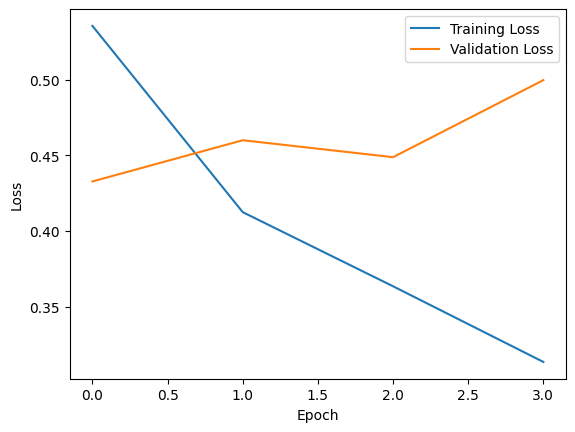

In [69]:
# Training the model and visualize losses
train_losses, val_losses =[], []
best_val_loss = float('inf')
patience = 3
patience_counter = 0

for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        train_loss = train(custom_model, train_dataloader, optimizer, scheduler, device)
        val_loss, accuracy, f1, precision, recall = evaluate(custom_model, val_dataloader, device)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        print(f"Train Loss:  {train_loss:.4f}, Val Loss: {val_loss:.4f} Validation Accuracy: {accuracy:.4f} Validation f1 score: {f1:.4f}, Precision score: {precision:.4f}, Recall: {recall:.4f}")


        # Save the best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(custom_model.state_dict(), f'best_custom_{model_name}_model.pt')
            patience_counter = 0
        else:
            patience_counter += 1

        # Early stopping
        if patience_counter >= patience:
            print(f'Early stopping at epoch {epoch + 1}')
            break
# Graphical visualization of the losses
plot_training_val_losses(train_losses, val_losses)

In [70]:
# Prediction on new an seen data using custom model
custom_model.load_state_dict(torch.load(f'best_custom_{model_name}_model.pt'))
custom_model.to(device)

# Evaluate the model
_, accuracy, f1, precision, recall = evaluate(custom_model, train_dataloader, device)

print(f'\n\nPrediction on test set using custom_{model_name}\n')
print("=" * 50 + "\n")
print(f'Accuracy: {accuracy:.4f} f1 score: {f1:.4f} Precision score: {precision:.4f}, Recall: {recall:.4f}')

_, accuracy, f1, precision, recall = evaluate(custom_model, test_dataloader, device)

print(f'\n\nPrediction on test set using custom_{model_name}\n')
print("=" * 50 + "\n")
print(f'Accuracy: {accuracy:.4f} f1 score: {f1:.4f}, Precision score: {precision:.4f}, Recall: {recall:.4f}')


<ipython-input-70-8b5af56b9c01>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  custom_model.load_state_dict(torch.load(f'best_custom_{model_name}_model.pt'))




Prediction on test set using custom_deberta


Accuracy: 0.8186 f1 score: 0.8170 Precision score: 0.8162, Recall: 0.8186


Prediction on test set using custom_deberta


Accuracy: 0.8349 f1 score: 0.8285, Precision score: 0.8291, Recall: 0.8349
